# Numerical analysis project
### Valeria Insogna
December 2022

In [1]:
%matplotlib inline
from numpy import *
from matplotlib.pyplot import *
import scipy.linalg

## 1. Exercise one

Consider the following one-dimensional PDE:
$$
-u_{xx}(x) = f(x)\quad\mathrm{ in }\ \Omega = (0, \pi)
$$
$$
u(x) = 0, \quad\mathrm{ on }\ \partial\Omega = \{0, \pi\}
$$

Given the following $4^{th}$ order finite difference approximation of the second order derivative:

$$u_{xx}(x_i) = \frac{-u_{i-2}+16u_{i-1}-30u_i+16u_{i+1}-u_{i+2}}{12h^2}$$

ImplemeM a function that given the domain iMerval, the forcing function, the number of discretization poiMs (<b> equispaced ?</b>), the boundary conditions, returns the matrix $A$ and the the right hand side $b$.

In [2]:
def finDif(omega,f,n,bc):
    assert n >= 3 #at least the bounderies + 1 middle poiM
    assert type(omega) is list
    assert type(bc) is list
    assert len(omega) == 2
    assert len(bc) == 2
    assert omega[0] < omega[-1]
    
    # Get size of each subiMerval  (𝑥𝑖,𝑥𝑖+1):
    h = 1./(n-1) 

    # Extract domain boundaries:
    start = omega[0]
    end = omega[-1]
    
    # Evaluate forcing function on grid poiMs:
    x = linspace(start,end,n)
    b = f(x) #rhs
    
    # Using 4𝑡ℎ order FD of 2nd derivative:
    aij2 = 1*ones((n-2,)) # Second Offdiagonal eMries
    aij1 = -16*ones((n-1,)) # First Offdiagonal eMries
    aii = +30*ones((n,)) # Diagonal eMries
    A = (diag(aij2, -2) + diag(aij1, -1) + diag(aii, 0) + diag(aij1, +1) + diag(aij2, +2))
    
    # Change first row of the matrix A and rhs
    A[0,:] = 0
    A[:,0] = 0
    A[0,0] = 1
    b[0] = bc[0]

    # Change last row of the matrix A and rhs
    A[-1,:] = 0
    A[:,-1] = 0
    A[-1,-1] = 1
    b[-1] = bc[-1]
    
    A /= 12*h**2
    
    return A, b

Call the function using:

In [3]:
omega = [0,pi]
f = lambda x : sin(x)
n=100
bc = [0,0]
A, b = finDif(omega, f, n, bc)

print(A)

[[   816.75      0.        0.   ...      0.        0.        0.  ]
 [     0.    24502.5  -13068.   ...      0.        0.        0.  ]
 [     0.   -13068.    24502.5  ...      0.        0.        0.  ]
 ...
 [     0.        0.        0.   ...  24502.5  -13068.        0.  ]
 [     0.        0.        0.   ... -13068.    24502.5       0.  ]
 [     0.        0.        0.   ...      0.        0.      816.75]]


ImplemeM two functions that compute the LU and the Cholesky factorization of the system matrix $A$

In [4]:
def LU(A):
    A = A.copy()
    N=len(A)
    for k in range(N-1):
        if (abs(A[k,k]) < 1e-15):
            raise RuMimeError("Null pivot")
            
        A[k+1:N,k] /= A[k,k]
        for j in range(k+1,N):
            A[k+1:N,j] -= A[k+1:N,k]*A[k,j]
    
    L=tril(A)
    for i in range(N):
        L[i,i]=1.0
    U = triu(A)
    return L, U

L, U = LU(A)

In [5]:
def cholesky(A):
    """Performs a Cholesky decomposition of A, which must 
    be a symmetric and positive definite matrix. The function
    returns the lower variaM triangular matrix, L."""
    A = A.copy()
    N = len(A)
    for k in range(N-1):
        A[k,k] = sqrt(A[k,k])
        A[k+1:N,k] = A[k+1:N,k]/A[k,k]
        
        for j in range(k+1,N):
            A[j:N,j] = A[j:N,j] - A[j:N,k]*A[j,k]
        
    A[-1,-1] = sqrt(A[-1,-1])
    L=tril(A)
    return L, L.transpose()

HT, H = cholesky(A)#upper triangular

ImplemeM forward and backward substitution functions to exploit the developed factorization methods to solve the derived linear system of equations.

In [6]:
def L_solve(L,rhs):
    x = zeros_like(rhs)
    N = len(L)
        
    x[0] = rhs[0]/L[0,0]
    for i in range(1,N):
        x[i] = (rhs[i] - dot(L[i, 0:i], x[0:i]))/L[i,i]
    
    return x

In [7]:
def U_solve(U,rhs):
    x = zeros_like(rhs)
    N = len(U)
        
    x[-1] = rhs[-1]/U[-1,-1]
    for i in reversed(range(N-1)):
        x[i] = (rhs[i] - dot(U[i, i+1:N], x[i+1:N]))/U[i,i]
    
    return x

Solve the derived linear system using the implemeMed functions and plot the computed solution:

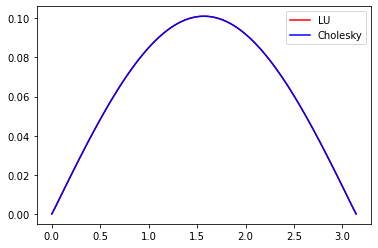

In [8]:
# Using LU
y = L_solve(L,b)
u_LU = U_solve(U,y)

# Using Cholesky
w = L_solve(HT,b)
u_Ch = U_solve(H,w)

x = linspace(omega[0],omega[-1],n)
_ = plot(x,u_LU,'r', label='LU')
_ = plot(x,u_Ch,'b', label='Cholesky')
_ = legend()

## 2. Exercise two

Considering the new domain $\Omega = (0,1)$ and the forcing term $f(x) = x(1-x)$ with B.C. $u(x) = 0$, on $\partial \Omega = {0,1}$ produce a plot and a table where you show the decay of the error w.r.t. the number of grid poiMs.
(The analytical solution for the above problems is $u_{an} = \frac{x^4}{12} - \frac{x^3}{6} + \frac{x}{12}$)

Then with $ n \in (3, 300)$:

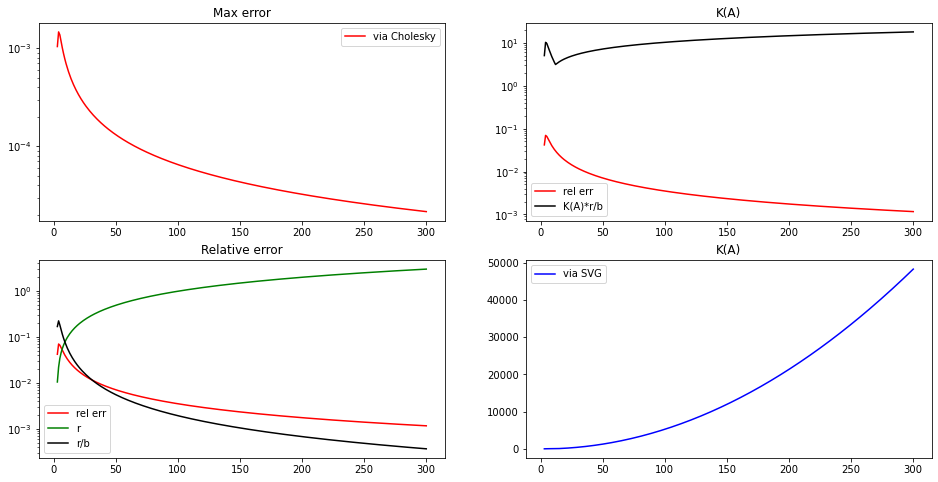

In [9]:
u_ex = lambda x : (x**4)/12. - (x**3)/6. + x/12.
omega = [0,1]
f = lambda x : x*(1.-x)
bc = [0,0]

N = range(3, 301)
max_errors = zeros(len(N))
cond_nums = zeros(len(N))
residuals = zeros(len(N))
rel_errors = zeros(len(N))
residuals_b = zeros(len(N))

for n in N:
    A, b = finDif(omega, f, n, bc)
    HT, H = cholesky(A)
    y = L_solve(HT,b)
    u = U_solve(H,y)
    x = linspace(omega[0],omega[-1],n)
    max_errors[n-3] = max(abs(u_ex(x)-u))
    cond_nums[n-3] = linalg.cond(A)
    residuals[n-3] = linalg.norm(b - dot(A,u_ex(x)),2)
    rel_errors[n-3] = linalg.norm(u_ex(x)-u,2)/linalg.norm(u,2)# euclidean norm
    residuals_b[n-3] = rel_errors[n-3]/linalg.norm(b,2)

#_ = semilogy(N,errors,'r', label='Cholesky')
#_ = legend()

figure, axis = subplots(2, 2, figsize = (16,8))
  
# For Max Errors
axis[0,0].semilogy(N,max_errors,'r', label='via Cholesky')
axis[0,0].set_title("Max error")

# For Relative Errors
axis[1,0].semilogy(N,rel_errors,'r', label='rel err')
axis[1,0].semilogy(N,residuals,'g', label='r')
axis[1,0].semilogy(N,residuals_b,'k', label='r/b')
axis[1,0].set_title("Relative error")

# For Condition number
axis[1,1].plot(N,cond_nums,'b', label='via SVG')
axis[1,1].set_title("K(A)")

# # For Gully
axis[0,1].semilogy(N,rel_errors,'r', label='rel err')
axis[0,1].semilogy(N,residuals_b*cond_nums,'k', label='K(A)*r/b')
axis[0,1].set_title("K(A)")

axis[0,0].legend(loc='best')
axis[1,0].legend(loc='best')
axis[1,1].legend(loc='best')
axis[0,1].legend(loc='best')
show()

The relative error infact is bounded by K(A):
$$
\frac{\| x - x_{true} \|}{\| x \|} \leq K(A) \frac{ \| r \|}{\| b \|}
$$

where the norm is the euclidean norm and r is the residual:
$$
r = b -Ax_{true}
$$

## 3. Exercise three

Exploit the derived LU factorizations to compute the condition number of the system's matrix $A$ using the original problem formulation.

Recall:
$$
\| A \|_{p=2} = sup_{x \ne 0} \frac{ \| Ax \|_{p=2}}{\| x \|_{p=2}}
$$

But if A is sdp $\implies$
$$
K(A) = \frac{ \lambda_{max}}{\lambda_{min}}
$$

In [10]:
def PM(A,z0,tol=1e-5,nmax=500):
    q = z0/linalg.norm(z0,2)
    it = 0
    err = tol + 1.
    while it < nmax and err > tol:
        z = dot(A,q)
        l = dot(q.T,z)
        err = linalg.norm(z-l*q,2)
        q = z/linalg.norm(z,2)
        
        it += 1
    print("error =", err, "iterations =", it)
    print("lambda_max =", l)
    return l,q

def IPM(A,x0,mu,tol=1e-5,nmax=500):
    M = A - mu*eye(len(A))
    P,L,U = scipy.linalg.lu(M)
    q = x0/linalg.norm(x0,2)
    it = 0
    err = tol + 1.
    while it < nmax and err > tol:
        y = scipy.linalg.solve_triangular(L, dot(P.T,q), lower=True)
        x = scipy.linalg.solve_triangular(U,y)
        z = dot(A,q)
        l = dot(q.T,z)
        err = linalg.norm(z-l*q,2)
        q = x/linalg.norm(x,2)
        it += 1
    print("error =", err, "iterations =", it)
    print("lambda =", l)
    return l,q


def condNumb(A, shift=0.):
    #initilal guess
    z0 = ones_like(x)
    l_max,q_max = PM(A,z0)
    l_min,q_min = IPM(A,z0,shift)
    #L, U = LU(A)
    condNu = l_max/l_min
    return condNu

In [11]:
n=100
h = 1./(n-1)
omega = [0,pi]
f = lambda x : sin(x)
bc = [0,0]
A, b = finDif(omega, f, n, bc)
x=linspace(omega[0],omega[-1],n)

print(condNumb(A))
linalg.cond(A) #2-norm, computed directly using the SVD: 5278 -> bad condition number


error = 55.65117039403209 iterations = 500
lambda_max = 52189.470999034995
error = 5.5182644893240295e-06 iterations = 8
lambda = 9.900512929599799
5271.390620884186


5278.068747923576

## 4. Exercise four

ImplemeM a preconditioned ConjugaM GradieM method to solve the original linear system of equations using an iterative method:

In [12]:
def conjugate_gradieM(A, b, P, nmax=len(A), eps=1e-10):
    x = zeros_like(b)
    tol = eps+1
    couM = 0
    r = b - dot(A,x)
    rho_old = 1.
    p_old = zeros_like(b)
    
    while(couM<nmax and tol>eps):
        couM += 1
        z = linalg.solve(P,r)
        rho = dot(r,z)
        if(couM > 1):
            beta = rho/rho_old
            p = z + beta*p_old
        else:
            p = z
        q = dot(A,p)
        alpha = rho/dot(p,q)
        x += p*alpha
        r -= q*alpha
        
        p_old = p
        rho_old = rho
        
        tol = linalg.norm(r,2)
        
    print("tolerance =", tol, "iterations =", couM)
    return x

In [14]:
# Recall:
f = sin(x)
f[-1] = 0
f[0] = 0

# Solution by direct method
u = linalg.solve(A, f) #used for comparison with iter methods

# Solution by conjugate gradieM
sol_gradieM = conjugate_gradieM(A, f, identity(len(A)))

print("conjugate gradieM distance respect direct method: ",linalg.norm(sol_gradieM - u)/linalg.norm(u))
sol_preconditioned_gradieM = conjugate_gradieM(A, f, A)
print("preconjugate gradieM distance respect direct method: ", linalg.norm(sol_preconditioned_gradieM - u)/linalg.norm(u))

tolerance = 6.1772350238470435e-12 iterations = 50
conjugate gradieM distance respect direct method:  3.052776264642868e-14
tolerance = 1.9137306222266202e-12 iterations = 1
preconjugate gradieM distance respect direct method:  2.6640386582648427e-14


## 5. Exercise five

Consider the following time dependeM variation of the PDE starting from the orginal problem formulation:
$$
u'(t)-u_{xx} = \alpha(t)f(x)
$$

for $t\in [0,T]$, with $\alpha(t) = \cos(t)$ and $T = 6\pi$

Use the same finite difference scheme to derive the semi-discrete formulation and solve it using a forward Euler's method.

Plot the time dependeM solution solution at $x = \pi/2$, $x=1$, 
$x=\pi$


The method will solve a problem of type:
$$\begin{cases}  
u_{x x}+\alpha(t) f(x)=\frac{\partial u}{\partial t}(t, x) & (t,x) \in (0,T] \times (a,b)\\
u(0,x)=g(x) & \forall x \in [a,b]\\
u(t,a)=p(t)\\
u(t,b)=q(t)\\
\end{cases}$$

### Approximation used
Let's start by discretizing time and substiting:
$$
u_{x x}+\alpha(t) f(x)=\frac{\partial u}{\partial t}(t, x) \Rightarrow u\left(t_{i+1},x\right)=u\left( t_{i},x\right)+h_{\mathrm{t}} u_{x x}\left( t_{i},x\right)+h_{\mathrm{t}} \alpha\left(t_{i}\right) f(x) \\
$$
Then let's discretize space:
$$u_{xx}(t,x_{j})=\frac{-u\left(t, x_{j-2}\right)+16 u\left(t, x_{j-1}\right)-30 u\left(t, x_{j}\right)+16 u\left(t, x_{j+1}\right)-u\left(t, x_{j+2}\right)}{12 h_{x}^{2}}$$


Hence:

\begin{aligned}
u\left(t_{i+1}, x_{j}\right) = h_{\mathrm{t}}\left(\frac{-u\left(t_{i}, x_{j-2}\right)+16 u\left(t_{i},x_{j-1}\right)-\left(30-12 h_{x}^{2} / h_{t}\right) u\left(t_{i},x_{j}\right)+16 u\left(t_{i}, x_{j+1}\right)-u\left(t_{i},x_{j+2}\right)}{12 h_{x}^{2}}+\alpha\left(t_{i}\right) f\left(x_{j}\right)\right)
\end{aligned}

However this discrete method does not work for $x=1$ and $x=N_{x}-1$. For this points we will use another approximation of x:
$$u_{xx}(t,x_{j})=\frac{u(t,x_{j-1})-2u(t,x_{j})+u(t,x_{j+1})}{h_{x}^{2}}$$ 

Hence substiting:
$$ 
u\left(t_{i+1}, x_{j}\right) = h_{\mathrm{t}}\left(\frac{ u\left(t_{i},x_{j-1}\right)-\left(2-h_{x}^{2} / h_{t}\right) u\left(t_{i},x_{j}\right)+ u\left(t_{i}, x_{j+1}\right)}{ h_{x}^{2}}+\alpha\left(t_{i}\right) f\left(x_{j}\right)\right)
$$

Vectorizing on the variable $x$ similarly to the first exercise we arrive at $\exists A$ s.t.
$$u(:,t_{i+1})=Au(:,t_{i})+h_{t}f(:)\alpha(t_{i})$$


In [15]:
def FinDif_time(f,alpha,M,N,a,b,T,g,q,p):
    
    x=linspace(a,b,N)
    t=linspace(0,T,M)

    ht=T/M
    hx=(b-a)/N
    
    A=zeros((N,N),dtype=float)
    for i in range(2,N-2):
        A[i, i-1] = A[i, i+1] = 16/12
        A[i, i-2] = A[i, i+2] = -1/12
        A[i,i] = (-30+12*hx**2/ht)/12

    A[1,0]=A[1,2]=A[N-2,N-3]=A[N-2,N-1]=1
    A[1,1]=A[N-2,N-2]=(-2+hx**2/ht)
    A[0,0] = A[-1,-1]=1
    
    A=ht*A/hx**2

    fx=f(x)
    alpha_t=alpha(t)
    
    U=zeros((M,N),dtype=float)
    U[0,:]=g(x)

    U[:,0]=p(t)
    U[:,N-1]=q(t)

    for i in range(1,M):
        U[i,:]=dot(A,U[i-1,:])+ht*fx*alpha_t[i]
      
    return U



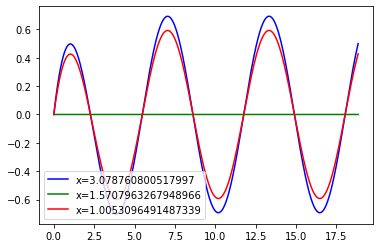

In [22]:
a=0
b=pi
T=6*pi
q = lambda x: 0
p = lambda x:0
f = lambda x : sin(x)
alpha = lambda x: cos(x)
g = lambda x: 0
N=50
M=100000
sol=FinDif_time(f,alpha,M,N,a,b,T,g,p,q)

# 3 solutions at x=pi/2, pi, 1
x1=argmin(abs(linspace(a,b,N)-pi))*(b-a)/N
x2=argmin(abs(linspace(a,b,N)-pi/2))*(b-a)/N
x3=argmin(abs(linspace(a,b,N)-1))*(b-a)/N

plot(linspace(0,T,M),sol[:,argmin(abs(linspace(a,b,N)-pi/2))], '-b', label='x={}'.format(x1))
plot(linspace(0,T,M),sol[:,argmin(abs(linspace(a,b,N)-pi))], '-g',label='x={}'.format(x2))
plot(linspace(0,T,M),sol[:,argmin(abs(linspace(a,b,N)-1))], '-r',label='x={}'.format(x3))
matplotlib.pyplot.legend()

## 6. Exercise six

Given the original $Au = b$ system, implemeM an algorithm to compute the eigenvalues and eigenvectors of the matrix $A$. Exploit the computed LU factorization

Oss. For a symmetric diagonalizable matrix $A$, it holds:
$$
A=\sum_{i=1}^{n}\lambda_{i}v_{i}v_{i}^{T}
$$
where $v_{i}$ and $\lambda_{i}$ are the i-th eigenvector and eigenvalue.

In [17]:
def eigendecomposition(A,nmax=500,tol=1e-08):
    n=len(A)
    d=zeros(n)
    V=zeros([n,n])
    z0=ones(n)
    for i in range(n):
        d[i],V[:,i]=PM(A,z0,tol,nmax)
        A=A-d[i]*outer(V[:,i],V[:,i])
    return d,V

In [18]:
eigenvalues=sort(linalg.eigvals(A))
eig,V=eigendecomposition(A,100000)
eig=sort(eig)
print('Relative error: ', linalg.norm(eigenvalues-eig)/linalg.norm(eigenvalues))

error = 9.995592640360748e-09 iterations = 6472
lambda_max = 52206.377870602286
error = 9.972003028110406e-09 iterations = 11710
lambda_max = 52255.58788210094
error = 9.97415575296612e-09 iterations = 3916
lambda_max = 52009.932429776716
error = 9.922894840174047e-09 iterations = 6091
lambda_max = 52124.448926095334
error = 9.972745170820404e-09 iterations = 2830
lambda_max = 51683.922306154345
error = 9.990938825535152e-09 iterations = 4044
lambda_max = 51863.011854552344
error = 9.944808527528158e-09 iterations = 2211
lambda_max = 51230.43122664053
error = 9.869514842357424e-09 iterations = 3132
lambda_max = 51472.94993583529
error = 9.981386370936463e-09 iterations = 9441
lambda_max = 50956.75215568806
error = 9.893955887892989e-09 iterations = 1812
lambda_max = 50652.34723530554
error = 9.949618208683398e-09 iterations = 8211
lambda_max = 50317.6984362823
error = 9.984097656593888e-09 iterations = 1537
lambda_max = 49953.3339968901
error = 9.935639457748709e-09 iterations = 6850
l

## 7. Exercise seven

Compute the inverse of the matrix A exploiting the derived LU factorization

In [19]:
def inverse(A):
    n=shape(A)[0]
    B=A.copy()
    I=eye(n)
    for i in range(n):
        B[:,i]=U_solve(U,L_solve(L,I[:,i]))
    return B

print('relative error: ', linalg.norm(linalg.inv(A)-inverse(A))/linalg.norm(linalg.inv(A)))

relative error:  1.7014257446248395e-14


## 8. Exercise eight

Consider the following Cauchy problem
$$
\begin{cases}
y'= -ty^2 \quad 0\le t \le 2\\
y(0) = 1
\end{cases}
$$
ImplemeM a Backward Euler's method in a suitable function and solve the resulting non-linear equation using a Newton's method.

In [20]:
f=lambda t,y: -t*(y**2)
df=lambda t,y: -t*2*y

# Newton method
def Newton(f,f1,x0,epsilon=1e-10,max_iter=500):
    x = x0
    for n in range(0,max_iter):
        if abs(f(x)) < epsilon:
            return x
        if f1(x) == 0:
            return None
        x = x - f(x)/f1(x)
    return x

# Backward euler
def backward_euler(y0,g,g1,omega,n):
    tspace=linspace(omega[0],omega[1],n)
    h=(omega[1]-omega[0])/n
    f=lambda t,z,x: z-h*g(t,z)-x
    df=lambda t,z,x: 1-h*g1(t,z)
    y=zeros(n)
    y[0]=y0
    for i in range(1,n):
        ft=lambda z: f(tspace[i],z,y[i-1])
        dft=lambda z: df(tspace[i],z,y[i-1])
        y[i]=Newton(ft,dft,y[i-1])
    return y

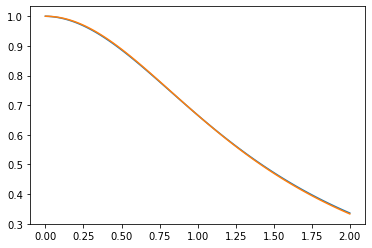

In [21]:
omega = [0,2]
n=100
y=backward_euler(1,f,df,omega,n)

plot(linspace(omega[0],omega[1],n),y)
plot(linspace(omega[0],omega[1],n),2/(linspace(omega[0],omega[1],n)**2+2))